# Lezione 9 − Equazioni differenziali

In questa lezione implementeremo dei programmi per risolvere equazioni differenziali. Come per la lezione della volta scorsa, mostro qui qual è il risultato atteso per gli esercizi, usando Julia.

A differenza della lezione precedente, non useremo `PyPlot` per produrre grafici, ma `Plots`: è più limitato, ma consente di creare facilmente animazioni.

In [1]:
using Plots
using Printf

# Esercizio 9.1: metodo di Eulero

Rispetto alla consegna dell'esercizio 9.1, noi non implementiamo una classe con metodo `Passo` (in Julia non esiste l'equivalente delle classi del C++), ma una funzione `euler` che restituisce una matrice a $N + 1$ colonne, dove $N$ è il numero di equazioni: la prima colonna contiene il tempo, le altre colonne le soluzioni delle $N$ variabili. Notate che in Julia non c'è bisogno di definire una classe base `FunzioneVettorialeBase` da cui derivare altre classi come `OscillatoreArmonico` eccetera: basta passare la funzione nel parametro `fn` (primo argomento).

In [2]:
function euler(fn, x0, startt, endt, h)
    timerange = startt:h:endt
    result = Array{Float64}(undef, length(timerange), 1 + length(x0))
    cur = x0
    for (i, t) in enumerate(timerange)
        result[i, 1] = t
        result[i, 2:end] = cur
        cur .+= fn(t, cur) * h
    end
    
    result
end

euler (generic function with 1 method)

Definiamo ora una funzione che descriva l'oscillatore armonico.

In [3]:
ω0 = 1.
oscillatore(time, x) = [x[2], -ω0^2 * x[1]]

oscillatore (generic function with 1 method)

Invochiamo `oscillatore` usando come condizione iniziale $(x, v) = (0, 1)$ e integrando nell'intervallo $0 \leq t \leq 70\,\text{s}$, usando come passo $h = 10^{-1}$. La funzione restituisce una matrice a tre colonne, contenenti il tempo, la posizione e la velocità.

In [4]:
result = euler(oscillatore, [0., 1.], 0.0, 70.0, 0.1)

701×3 Array{Float64,2}:
  0.0    0.0        1.0
  0.1    0.1        1.0
  0.2    0.2        0.99
  0.3    0.299      0.97
  0.4    0.396      0.9401
  0.5    0.49001    0.9005
  0.6    0.58006    0.851499
  0.7    0.66521    0.793493
  0.8    0.744559   0.726972
  0.9    0.817256   0.652516
  1.0    0.882508   0.57079
  1.1    0.939587   0.48254
  1.2    0.987841   0.388581
  ⋮                
 68.9  -13.2168    27.8328
 69.0  -10.4335    29.1545
 69.1   -7.51806   30.1979
 69.2   -4.49827   30.9497
 69.3   -1.4033    31.3995
 69.4    1.73665   31.5398
 69.5    4.89063   31.3662
 69.6    8.02725   30.8771
 69.7   11.115     30.0744
 69.8   14.1224    28.9629
 69.9   17.0187    27.5506
 70.0   19.7737    25.8488

Stampiamo in particolare l'ultima riga del codice:

In [5]:
result[end, :]

3-element Array{Float64,1}:
 70.0
 19.773746013860173
 25.84877475152296

Il risultato sopra dovrebbe esservi utile per scrivere dei test nel vostro codice usando `assert`:

```c++
#include "EquazioniDifferenziali.hpp"
#include <cstdio>
#include <cassert>
#include <cmath>

bool is_close(double a, double b, double epsilon = 1e-8) {
    return std::fabs(a - b) < epsilon;
}

void test_euler() {
  Eulero eulero;
  OscillatoreArmonico oa{1.0};
  const double lastt{70.0};
  const double h{0.1};
  std::vector<double> pos{0.0, 1.0};

  for (double t{}; t <= lastt; t += h) {
    pos = eulero.Passo(t, pos, h, &oa);
  }

  assert(is_close(pos[0], 19.773746013860173));
  assert(is_close(pos[1], 25.848774751522960));
}
```

Per studiare il funzionamento di `euler`, consideriamo la simulazione nell'intervallo usato sopra, $0 \leq t \leq 70\,\text{s}$. Dichiariamo quindi la variabile `lastt` (nel vostro codice dovreste definirla come un `const double`, ma in un notebook destinato all'uso interattivo come questo non è mai consigliato definire costanti).

In [6]:
lastt = 70.0;

Nello stabilire il passo di integrazione occorre fare un'osservazione **molto importante**: se vogliamo paragonare la soluzione calcolata da `euler`, possiamo semplicemente paragonare l'ultimo valore di `pos.GetComponente(0)` col valore $\sin 70$. Ma questo funziona se effettivamente il valore della variabile `t` durante l'ultima iterazione del ciclo `for` è uguale a 70, e questo vale solo se $\Delta t = 70\,\text{s}$ è esattamente divisibile per $h$. Non scegliete quindi a caso i valori di $h$, ma definiteli in funzione del numero di passi che volete far compiere.

Nel codice Julia definiamo `nsteps` come un vettore di valori della forma $7 \times 10^k$, con $k \in [2, 2.2, 2.4, 2.6, \ldots 3.8, 4]$: in questo modo gli estremi sono 700 e 70000, pari ad $h = 10^{-1}$ e $h = 10^{-3}$. Il valore di `nsteps` deve ovviamente essere sempre arrotondato ad un intero (mediante `round`).

In [7]:
nsteps = 7 * round.(Int, exp10.(2:0.2:4))

11-element Array{Int64,1}:
   700
  1106
  1757
  2786
  4417
  7000
 11095
 17584
 27867
 44170
 70000

Questi sono i passi temporali (ossia, i valori di $h$) che studieremo più sotto.

In [8]:
deltat = lastt ./ nsteps

11-element Array{Float64,1}:
 0.1
 0.06329113924050633
 0.0398406374501992
 0.02512562814070352
 0.01584786053882726
 0.01
 0.006309148264984227
 0.003980891719745223
 0.0025119316754584277
 0.001584786053882726
 0.001

Creiamo ora un'animazione che confronti la soluzione analitica esatta $f(x) = \sin x$ con la soluzione calcolata col metodo `euler`. In Julia è semplicissimo creare animazioni: basta usare la macro `@animate` del pacchetto `Plots`, e poi salvare il risultato in un file GIF.

┌ Info: Saved animation to 
│   fn = /home/tomasi/Documents/corsi/laboratorio_calcolo/tnds-tomasi-notebooks/euler.gif
└ @ Plots /home/tomasi/.julia/packages/Plots/8GUYs/src/animation.jl:102


Plots.AnimatedGif("/home/tomasi/Documents/corsi/laboratorio_calcolo/tnds-tomasi-notebooks/euler.gif")
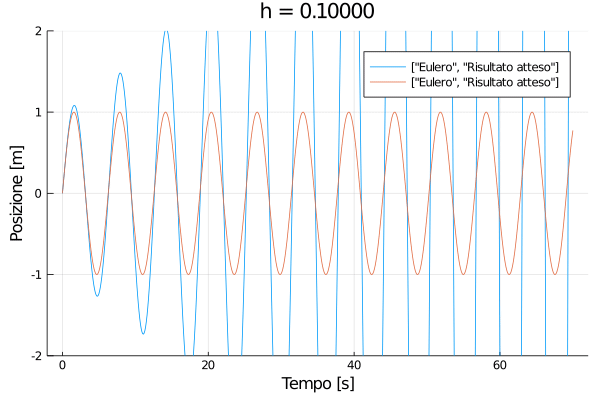

In [9]:
anim = @animate for h in deltat
    result = euler(oscillatore, [0., 1.], 0.0, 70.0, h)
    plot(result[:, 1], [result[:, 2], sin.(result[:, 1])], 
        title = @sprintf("h = %.5f", h),
        label=["Eulero", "Risultato atteso"], ylim=(-2, 2),
        xlabel="Tempo [s]", ylabel="Posizione [m]")
end

gif(anim, "euler.gif", fps = 1)

Vediamo che l'errore è estremamente significativo se $h = 10^{-2}$. Facciamo un confronto più quantitativo confrontando il valore della posizione all'istante $t = 70\,\mathrm{s}$ con quello teorico.

In [10]:
lastpos = [euler(oscillatore, [0., 1.], 0.0, lastt, h)[end, 2] for h in deltat]
error_euler = abs.(lastpos .- sin(lastt))

@printf("%-14s\t%-14s\n", "δt [s]", "x(70) [m]")
for i in 1:length(deltat)
    @printf("%.12f\t%.12f\n", deltat[i], lastpos[i])
end

δt [s]        	x(70) [m]     
0.100000000000	19.773746013860
0.063291139241	6.491353718714
0.039840637450	3.020870585603
0.025125628141	1.841466606636
0.015847860539	1.341055498792
0.010000000000	1.096084090818
0.006309148265	0.964380218087
0.003980891720	0.889320788243
0.002511931675	0.844907752921
0.001584786054	0.817989996041
0.001000000000	0.801441124227


I numeri sopra vi saranno preziosi per fare test sul vostro codice usando `assert`. Creiamo ora un plot che mostri l'andamento dell'errore in funzione del passo $h$, come mostrato sul sito (http://labmaster.mi.infn.it/Laboratorio2/labTNDS/lectures_1819/lezione9_1819.html).

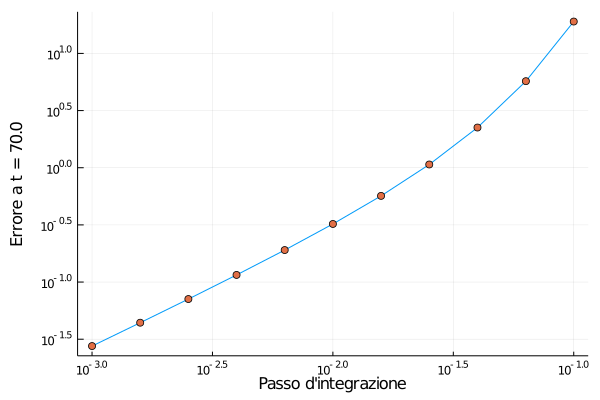

In [11]:
plot(deltat, error_euler,
     xscale = :log10, yscale = :log10,
     xlabel = "Passo d'integrazione",
     ylabel = @sprintf("Errore a t = %.1f", lastt),
     label = "")
scatter!(deltat, error_euler, label = "")

# Esercizio 9.2

La funzione `rungekutta` implementa l'integrazione di Runge-Kutta usando lo stesso approccio della funzione `euler` vista sopra: è quindi un po' diverso dal modo in cui la implementerete voi.

In [12]:
function rungekutta(fn, x0, startt, endt, h)
    timerange = startt:h:endt
    result = Array{Float64}(undef, length(timerange), 1 + length(x0))
    cur = x0
    for (i, t) in enumerate(timerange)
        result[i, 1] = t
        result[i, 2:end] = cur

        k1 = fn(t,          cur)
        k2 = fn(t + h / 2., cur .+ k1 .* h / 2.0)
        k3 = fn(t + h / 2., cur .+ k2 .* h / 2.0)
        k4 = fn(t + h,      cur .+ k3 .* h)
        
        cur .+= (k1 .+ 2k2 .+ 2k3 .+ k4) .* h / 6
    end
    
    result
end

rungekutta (generic function with 1 method)

Il funzionamento di `rungekutta` è però il medesimo di `euler`: le due funzioni accettano gli stessi parametri e restituiscono matrici a tre colonne.

In [13]:
result = rungekutta(oscillatore, [0., 1.], 0.0, 70.0, 0.1)

701×3 Array{Float64,2}:
  0.0   0.0        1.0
  0.1   0.0998333  0.995004
  0.2   0.198669   0.980067
  0.3   0.29552    0.955337
  0.4   0.389418   0.921061
  0.5   0.479425   0.877583
  0.6   0.564642   0.825336
  0.7   0.644217   0.764843
  0.8   0.717356   0.696707
  0.9   0.783326   0.621611
  1.0   0.84147    0.540303
  1.1   0.891207   0.453597
  1.2   0.932039   0.362359
  ⋮                
 68.9  -0.21344    0.976951
 69.0  -0.114841   0.993379
 69.1  -0.0150951  0.999881
 69.2   0.0848018  0.996393
 69.3   0.183851   0.982949
 69.4   0.281064   0.959684
 69.5   0.375468   0.92683
 69.6   0.466121   0.884716
 69.7   0.552116   0.833761
 69.8   0.632595   0.774476
 69.9   0.706754   0.707453
 70.0   0.77385    0.633361

In [14]:
result[end, :]

3-element Array{Float64,1}:
 70.0
  0.7738501114078689
  0.6333611095194112

Possiamo usare questi valori per scrivere una funzione `test_runge_kutta`, simile a `test_euler` (v. sopra):

```c++
void test_runge_kutta() {
  RungeKutta rk;
  OscillatoreArmonico oa{1.0};
  const double lastt{70.0};
  const double h{0.1};
  std::vector<double> pos{0.0, 1.0};

  for (double t{}; t <= lastt; t += h) {
    pos = rk.Passo(t, pos, h, &oa);
  }

  assert(is_close(pos[0], 0.7738501114078689));
  assert(is_close(pos[1], 0.6333611095194112));
}

```

Nel caso di Runge-Kutta, l'animazione è molto meno interessante: la convergenza è eccellente anche per $h = 10^{-1}$.

┌ Info: Saved animation to 
│   fn = /home/tomasi/Documents/corsi/laboratorio_calcolo/tnds-tomasi-notebooks/rk.gif
└ @ Plots /home/tomasi/.julia/packages/Plots/8GUYs/src/animation.jl:102


Plots.AnimatedGif("/home/tomasi/Documents/corsi/laboratorio_calcolo/tnds-tomasi-notebooks/rk.gif")
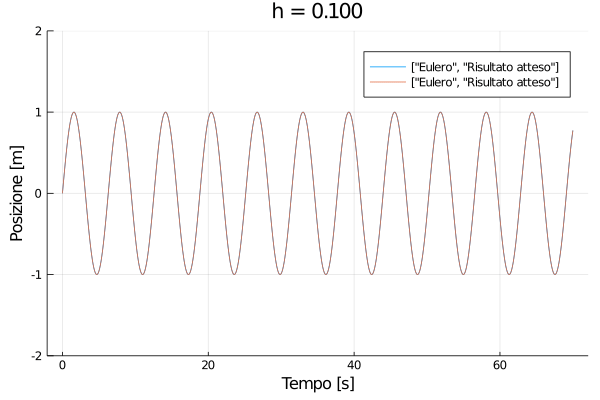

In [15]:
anim = @animate for h in deltat
    result = rungekutta(oscillatore, [0., 1.], 0.0, 70.0, h)
    plot(result[:, 1], [result[:, 2], sin.(result[:, 1])], 
        title = @sprintf("h = %.3f", h),
        label = ["Eulero", "Risultato atteso"],
        ylim = (-2, 2),
        xlabel = "Tempo [s]",
        ylabel = "Posizione [m]")
end

gif(anim, "rk.gif", fps = 1)

Confrontiamo il grafico dell'errore di Runge-Kutta con quello di Eulero, per rendere evidente la differenza nella velocità di convergenza.

In [16]:
lastpos = [rungekutta(oscillatore, [0., 1.], 0.0, lastt, h)[end, 2] for h in deltat]
error_rk = abs.(lastpos .- sin(lastt))

11-element Array{Float64,1}:
 4.0570150020236007e-5
 6.301458916779801e-6
 9.680016646029799e-7
 1.5096724137464435e-7
 2.3677510618824726e-8
 3.7318509393813315e-9
 5.891128695978409e-10
 9.315614946103778e-11
 1.4744427900836854e-11
 2.3335777754596165e-12
 3.597122599785507e-13

Questa è la corrispondenza tra $\delta t$ e la posizione finale (a $t = 70\,\mathrm{s}$):

In [17]:
@printf("%-14s\t%-14s\n", "δt [s]", "x(70) [m]")
for i in 1:length(deltat)
    @printf("%.12f\t%.12f\n", deltat[i], lastpos[i])
end

δt [s]        	x(70) [m]     
0.100000000000	0.773850111408
0.063291139241	0.773884380099
0.039840637450	0.773889713556
0.025125628141	0.773890530591
0.015847860539	0.773890657880
0.010000000000	0.773890677826
0.006309148265	0.773890680969
0.003980891720	0.773890681465
0.002511931675	0.773890681543
0.001584786054	0.773890681556
0.001000000000	0.773890681558


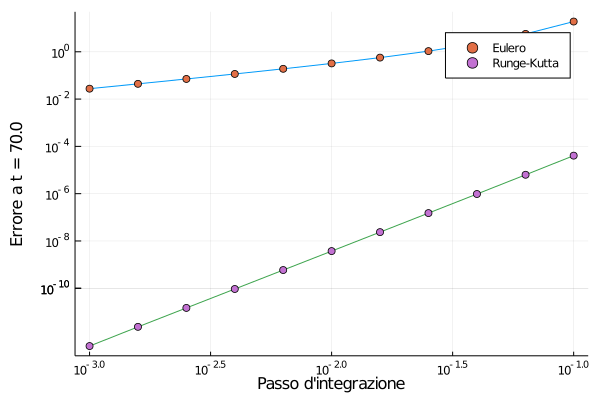

In [18]:
plot(deltat, error_euler, label = "")
scatter!(deltat, error_euler, label = "Eulero")

plot!(deltat, error_rk,
     xscale = :log10, yscale = :log10,
     xlabel = "Passo d'integrazione",
     ylabel = @sprintf("Errore a t = %.1f", lastt),
     label = "")
scatter!(deltat, error_rk, label = "Runge-Kutta")

## Esercizio 9.3

Questo esercizio richiede di studiare il comportamento di un pendolo di lunghezza $l$ sottoposto ad un'accelerazione di gravità $g$. Impostiamo un paio di costanti.

In [19]:
rodlength = 1.
g = 9.81

9.81

La funzione `pendulum` definisce i due membri dell'equazione differenziale di secondo grado.

In [20]:
pendulum(t, x) = [x[2], -g / rodlength * sin(x[1])]

pendulum (generic function with 1 method)

Prima di effettuare lo studio richiesto dall'esercizio, è buona norma studiare il comportamento della soluzione in un caso particolare. Usiamo `rungekutta` per analizzare il caso in cui $\theta_0 = \pi/3$:

In [21]:
oscillations = rungekutta(pendulum, [π / 3, 0.], 0.0, 3.0, 0.01)

301×3 Array{Float64,2}:
 0.0    1.0472     0.0
 0.01   1.04677   -0.0849501
 0.02   1.0455    -0.169859
 0.03   1.04338   -0.254683
 0.04   1.04041   -0.339382
 0.05   1.03659   -0.423913
 0.06   1.03193   -0.508232
 0.07   1.02643   -0.592295
 0.08   1.02008   -0.676057
 0.09   1.01291   -0.759471
 0.1    1.00489   -0.842491
 0.11   0.996057  -0.925068
 0.12   0.986395  -1.00715
 ⋮                
 2.89  -0.58417   -2.56055
 2.9   -0.609502  -2.50541
 2.91  -0.634272  -2.44826
 2.92  -0.658461  -2.38917
 2.93  -0.682049  -2.32823
 2.94  -0.705019  -2.26552
 2.95  -0.727354  -2.20111
 2.96  -0.749036  -2.13509
 2.97  -0.770051  -2.06754
 2.98  -0.790382  -1.99853
 2.99  -0.810017  -1.92814
 3.0   -0.828941  -1.85645

È interessante studiare il pendolo creando un'animazione. Noi useremo il pacchetto `Luxor`, che consente di creare disegni ed animazioni partendo da forme geometriche primitive. Per installarlo, usate come al solito i comandi di `Pkg`:

```julia
import Pkg
Pkg.add("Luxor")
```

In [22]:
using Luxor

In Luxor, il disegno avviene su una superficie quadrata di dimensione $500\times 500$, con il centro del quadrato collocato alla coordinata $(0, 0)$. Noi disegnamo il pendolo come una linea che parte dal centro e alla cui estremità è disegnato un cerchio. (Notate che Julia offre il comando `sincos`, che calcola simultaneamente il valore del seno e del coseno di un angolo).

In [23]:
function plot_pendulum(angle)
    radius = 200
    y, x = radius .* sincos(π / 2 + angle)
    
    sethue("black")
    line(Point(0, 0), Point(x, y), :stroke)
    circle(Point(x, y), 10, :fill)
end

plot_pendulum (generic function with 1 method)

Per "eseguire" le funzioni di disegno, la macro `@png` è molto comoda. Usiamola per verificare il funzionamento di `plot_pendulum`:

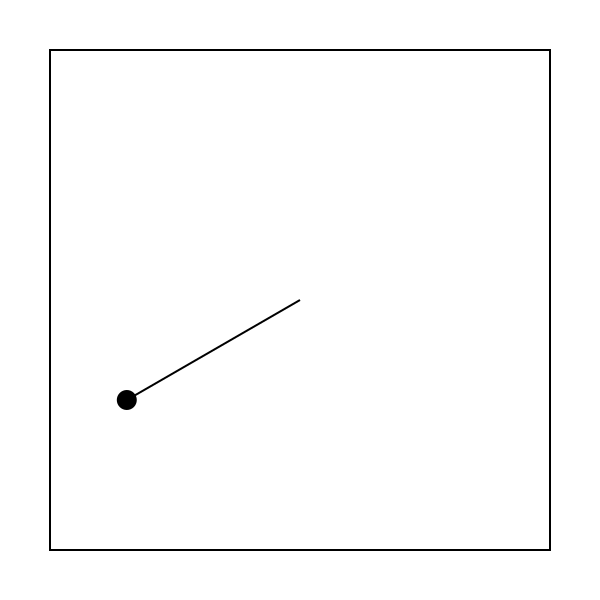

In [24]:
@png begin
    # Disegna una cornice
    box(Point(-250, -250), Point(250, 250), :stroke)
    
    # Disegna il pendolo
    plot_pendulum(π / 3)
end

Abbiamo già calcolato la soluzione dell'equazione in un caso particolare, e il risultato è nella matrice `oscillations`. Il comando `size` restituisce le dimensioni di vettori, matrici e tensori. Nel caso di `oscillations` ci sono ovviamente 3 colonne, ma il numero di righe (corrispondente agli step temporali) dipende dal passo $h$ e dalla lunghezza della simulazione. Vediamo di quanti step si tratta:

In [25]:
size(oscillations, 1)

301

Creeremo ora un'immagine GIF animata chiamando ripetutamente il comando `plot_pendulum`. Notate la comodità di Luxor: in poche righe è possibile creare un'intera animazione e salvarla su disco.

In [26]:
anim = Movie(500, 500, "Pendulum")

function animframe(scene, framenumber)
    background("white")
    plot_pendulum(oscillations[framenumber, 2])
end

Luxor.animate(anim, [Scene(anim, animframe, 1:size(oscillations, 1))],
    creategif=true, pathname="pendulum.gif");

┌ Info: Frames for animation "Pendulum" are being stored in directory: 
│ 	 /tmp/jl_d2ryfS
└ @ Luxor /home/tomasi/.julia/packages/Luxor/Sul91/src/animate.jl:177
┌ Info: ... 301 frames saved in directory:
│ 	 /tmp/jl_d2ryfS
└ @ Luxor /home/tomasi/.julia/packages/Luxor/Sul91/src/animate.jl:199
┌ Info: GIF is: pendulum.gif
└ @ Luxor /home/tomasi/.julia/packages/Luxor/Sul91/src/animate.jl:216


![](./pendulum.gif)

Adesso che abbiamo visto che l'equazione del pendolo viene integrata correttamente, dobbiamo passare al calcolo del periodo di oscillazione. Come suggerito sul sito, bisogna considerare il momento in cui la velocità angolare inverte il segno. Osserviamo allora il grafico della velocità (seconda componente del sistema di equazioni differenziali).

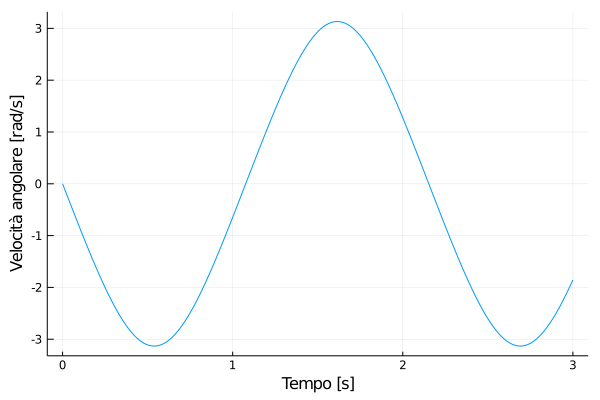

In [27]:
plot(oscillations[:, 1], oscillations[:, 3],
     label = "",
     xlabel = "Tempo [s]",
     ylabel = "Velocità angolare [rad/s]")

Possiamo farci un'idea del punto in cui avviene l'inversione usando i filtri offerti da Julia:

In [28]:
oscillations[abs.(oscillations[:, 3]) .< 0.1, :]

6×3 Array{Float64,2}:
 0.0    1.0472    0.0
 0.01   1.04677  -0.0849501
 1.07  -1.04702  -0.0546879
 1.08  -1.04714   0.030267
 2.15   1.04716   0.0244223
 2.16   1.04698  -0.0605321

Qui è evidente il problema accennato sul sito: non esiste alcun punto in cui la velocità angolare sia esattamente zero, perché stiamo usando un passo discreto per integrare l'equazione.

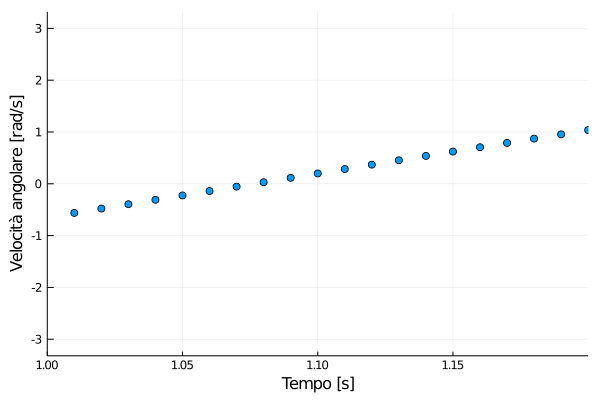

In [29]:
scatter(oscillations[:, 1], oscillations[:, 3],
        label = "",
        xlim = (1.0, 1.2),
        xlabel = "Tempo [s]",
        ylabel = "Velocità angolare [rad/s]")

Implementiamo quindi una funzione per cercare l'inversione di segno in un vettore. (È buona cosa che anche voi implementiate una funzione del genere nel vostro codice C++).

In [30]:
function search_inversion(vect)
    prevval = vect[1]
    for i in 2:length(vect)
        if prevval * vect[i] < 0
            return i - 1
        end
        prevval = vect[i]
    end
    
    println("No inversion found, run the simulation for a longer time")
end

search_inversion (generic function with 1 method)

La funzione restituisce l'indice dell'ultimo elemento del vettore *prima* dell'inversione. Nella vostra versione in C++ quindi la funzione dovrà restituire un intero. Verifichiamone il funzionamento su un vettore (ricordando che in Julia gli elementi dei vettori si contano da 1 anziché da 0 come in C++!).

In [31]:
search_inversion([4, 3, 1, -2, -5])

3

La formula per l'interpolazione lineare $t = t(\omega)$ tra due punti $(t_A, \omega_A)$ e $(t_B, \omega_B)$ si ricava imponendo che $t(\omega_A) = t_A$ e che $t(\omega_B) = t_B$. Il risultato è
$$
t(\omega) = t_A + \frac{t_A - t_B}{\omega_A - \omega_B}\bigl(\omega - \omega_A\bigr).
$$

Nel nostro caso bisogna quindi implementare il calcolo della formula nel caso in cui $\omega = 0$, e **raddoppiare il risultato**: lo facciamo nella funzione `period`, che accetta come parametro la matrice a tre colonne prodotta da `euler` o `rungekutta`, e che sfrutta la funzione `invtime` che fornisce il valore del tempo all'istante della inversione. Implementiamo una serie di sotto-funzioni, in modo che sia più facile verificare il comportamento di ciascuna.

In [32]:
interp(ptA, ptB, x) = ptA[1] + (ptA[1] - ptB[1]) / (ptA[2] - ptB[2]) * (x - ptA[2])
interp(ptA, ptB) = interp(ptA, ptB, 0)

interp (generic function with 2 methods)

Eseguiamo una volta `interp`: il valore restituito è utile per scrivere nel vostro codice un test con `assert`!

In [33]:
interp((-0.4, -0.7), (0.5, 0.8), 0.3)

0.19999999999999996

La funzione `invtime` mette insieme `search_inversion` e `interp` per restituire l'istante temporale in cui avviene l'inversione del segno del vettore `vec`:

In [34]:
function invtime(time, vec)
    idx = search_inversion(vec)
    timeA, timeB = time[idx:idx + 1]
    vecA, vecB = vec[idx:idx + 1]
    
    abs(interp((timeA, vecA), (timeB, vecB)))
end

invtime (generic function with 1 method)

Siccome in questo esercizio assumiamo sempre di iniziare dalla posizione $\theta = 0$, il valore del periodo è semplicemente il doppio del tempo necessario per osservare l'inversione (nell'esercizio 9.4 questo **non sarà più vero**, ricordatevelo!).

In [35]:
period(oscillations) = 2 * invtime(oscillations[:, 1], oscillations[:, 3])

period (generic function with 1 method)

Chiamando `period` su una matrice restituita da `euler` o da `rungekutta` si ottiene quindi il periodo di oscillazione.

In [36]:
period(oscillations)

2.152874570427233

Confrontiamola col periodo ideale di un pendolo sottoposto a piccole oscillazioni.

In [37]:
ideal_period = 2π / √(g / rodlength)

2.006066680710647

Creiamo ora il grafico analogo a quello riportato sul sito del corso.

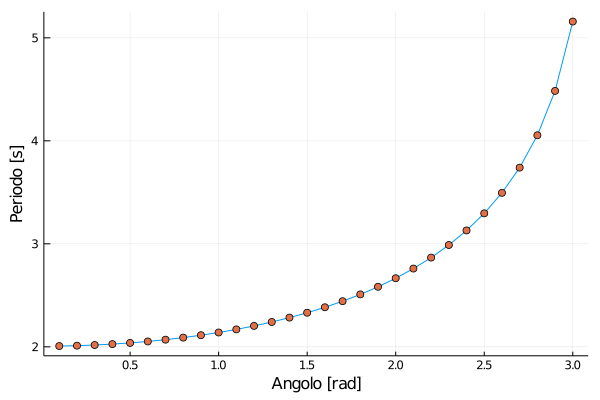

In [38]:
angles = 0.1:0.1:3.0
ampl = [period(rungekutta(pendulum, [angle, 0.], 0.0, 3.0, 0.01)) for angle in angles]
plot(angles, ampl, label="", xlabel="Angolo [rad]", ylabel="Periodo [s]")
scatter!(angles, ampl, label="")

Ecco alcuni dei valori in una tabella che associa ampiezza (in radianti) e periodo (in secondi). In questo modo potrete confrontarli con l'output del vostro programma, magari mediante alcuni test con `assert` (usate ad esempio il primo e l'ultimo).

In [39]:
[angles ampl]

30×2 Array{Float64,2}:
 0.1  2.00732
 0.2  2.01109
 0.3  2.01741
 0.4  2.02631
 0.5  2.03787
 0.6  2.05216
 0.7  2.06928
 0.8  2.08938
 0.9  2.1126
 1.0  2.13914
 1.1  2.16921
 1.2  2.20308
 1.3  2.24107
 ⋮    
 1.9  2.58282
 2.0  2.66587
 2.1  2.75966
 2.2  2.86625
 2.3  2.98837
 2.4  3.12979
 2.5  3.29593
 2.6  3.49491
 2.7  3.73983
 2.8  4.05387
 2.9  4.48458
 3.0  5.15807

## Esercizio 9.4

Come sopra, definiamo i parametri numerici del problema.

In [40]:
ω0 = 10;
α = 1.0 / 30;

Trattandosi di un esercizio complesso, definiamo una funzione che invochi `rungekutta` con dei parametri sensati. Notate la sintassi `do...end`, che in Julia permette di passare come primo argomento di una funzione (nel nostro caso appunto `rungekutta`) una seconda funzione. Questa sintassi è molto comoda per casi come il nostro.

In [41]:
function forcedpendulum(ω; init=[0., 0.], startt=0., endt=15. / α, deltat=0.01)
    rungekutta(init, startt, endt, deltat) do t, x
        [x[2], -ω0^2 * x[1] - α * x[2] + sin(ω * t)]
    end
end

forcedpendulum (generic function with 1 method)

Il valore di ritorno di `forcedpendulum` è come al solito una matrice a tre colonne. Il plot mostra come il pendolo forzato con smorzante arrivi presto ad una situazione di equilibrio:

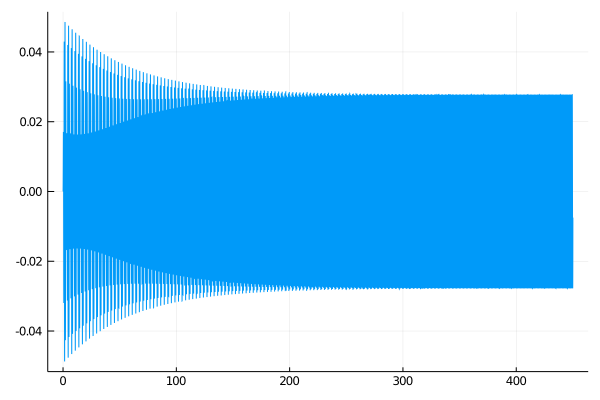

In [42]:
oscillations = forcedpendulum(8.)
plot(oscillations[:, 1], oscillations[:, 2], label="")

Rispetto all'esercizio precedente, dobbiamo calcolare qui non il periodo bensì l'ampiezza di oscillazione (che nell'esercizio precedente era fissata dalla condizione iniziale). Come prima, anche qui non possiamo avere la garanzia che l'integrazione con RK passerà dall'istante in cui il valore della velocità si annulla esattamente. Il modo migliore di procedere è quindi il seguente:

1. Iteriamo RK per un tempo ragionevole in modo da toglierci dalla regione iniziale di instabilità; qui integro fino al tempo $15/\alpha$;
2. A questo punto il codice cerca nuovamente una inversione nel segno della velocità;
3. Trovata l'inversione, sappiamo che il massimo avviene in qualche istante che sta tra $t$ e $t + h$. Troviamo questo istante $t_\text{inv}$ con una interpolazione lineare tra il punto $(t, \omega_0)$ e $(t + h, \omega_1)$
4. Eseguiamo di nuovo RK partendo dal tempo $t$, ma questa volta non usiamo come incremento $h$ bensì $t_\text{inv} - t$
5. Se abbiamo fatto le cose per bene, dopo una *singola* esecuzione di RK ci troviamo in corrispondenza del massimo. Stampare la velocità in questo punto dovrebbe quindi mostrare un numero pressoché nullo
6. Se effettivamente la velocità è praticamente nulla (diciamo $\left|v\right| \leq 10^{-6}\,\text{rad/s}$, il valore della posizione in questo punto corrisponde all'ampiezza.

In [43]:
function forced_amplitude(ω, oscillations)
    # Per comodità estraggo la prima colonna della matrice (quella che
    # contiene i tempi) nel vettore "timevec"
    timevec = oscillations[:, 1]
    
    # Questa maschera serve per trascurare le oscillazioni nella prima
    # parte della simulazione, ossia le prime righe della matrice.
    # Di fatto quindi ci concentriamo solo sulla "coda" della soluzione,
    # ossia le ultime righe della matrice
    mask = timevec .> 10 / α
    oscill_tail = oscillations[mask, :]
    
    # Calcolo il tempo in corrispondenza della prima inversione
    # nella "coda" della soluzione
    idx0 = search_inversion(oscill_tail[:, 3])
    ptA = oscill_tail[idx0, [1, 3]]
    ptB = oscill_tail[idx0 + 1, [1, 3]]
    t0 = interp(ptA, ptB)
    δt = t0 - oscill_tail[idx0, 1]
    newsol = forcedpendulum(ω,
        init=oscill_tail[idx0, 2:3], 
        startt=oscill_tail[idx0, 1],
        endt=oscill_tail[idx0, 1] + 1.1 * δt,
        deltat=δt)
    
    @printf("t0 = %.4f, angle = %.4f, speed = %.4f, t0 + δt = %.4f, angle = %.4f, speed = %.4f\n",
        newsol[1, 1], newsol[1, 2], newsol[1,3], newsol[2, 1], newsol[2, 2], newsol[2, 3])
    abs(newsol[2, 2])
end

forced_amplitude (generic function with 1 method)

Chiamiamo la funzione `forced_amplitude` su un caso specifico: questo è un numero buono per essere usato in un `assert`. Notate che nel secondo punto (corrispondente al tempo $t + \delta t$) la velocità è nulla.

In [44]:
forced_amplitude(9.5, forcedpendulum(9.5))

t0 = 300.1000, angle = -0.1018, speed = -0.0709, t0 + δt = 300.1077, angle = -0.1020, speed = -0.0000


0.10203379178084179

Ricreiamo ora il grafico presente sul sito del corso. La funzione `forced_amplitude` stampa a video i due punti su cui esegue di nuovo il RK: potete verificare che il secondo punto è effettivamente quello di massimo, perché la velocità è pressoché nulla. Usate i numeri scritti qui sotto per verificare che il vostro codice sia corretto.

The frequencies to be sampled are: [9.01, 9.06, 9.11, 9.16, 9.21, 9.26, 9.31, 9.36, 9.41, 9.46, 9.51, 9.56, 9.61, 9.66, 9.71, 9.76, 9.81, 9.86, 9.91, 9.96, 10.01, 10.06, 10.11, 10.16, 10.21, 10.26, 10.31, 10.36, 10.41, 10.46, 10.51, 10.56, 10.61, 10.66, 10.71, 10.76, 10.81, 10.86, 10.91, 10.96, 11.01]
t0 = 300.0400, angle = 0.0532, speed = 0.0013, t0 + δt = 300.0403, angle = 0.0532, speed = -0.0000
t0 = 300.1100, angle = -0.0554, speed = -0.0325, t0 + δt = 300.1171, angle = -0.0555, speed = -0.0000
t0 = 300.1900, angle = 0.0591, speed = 0.0229, t0 + δt = 300.1947, angle = 0.0591, speed = -0.0000
t0 = 300.2700, angle = -0.0619, speed = -0.0087, t0 + δt = 300.2717, angle = -0.0619, speed = 0.0000
t0 = 300.3400, angle = 0.0658, speed = 0.0330, t0 + δt = 300.3459, angle = 0.0659, speed = 0.0000
t0 = 300.0800, angle = 0.0704, speed = 0.0164, t0 + δt = 300.0827, angle = 0.0704, speed = -0.0000
t0 = 300.1500, angle = -0.0744, speed = -0.0498, t0 + δt = 300.1577, angle = -0.0746, speed = -0.00

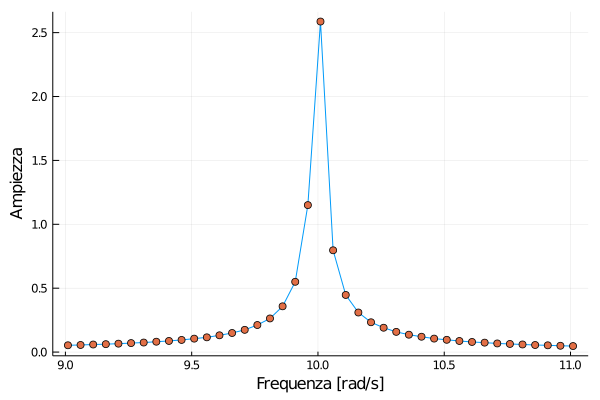

In [45]:
# Aggiungiamo 0.01 agli estremi (9 e 11) per evitare la condizione di risonanza
freq = 9.01:0.05:11.01
println("The frequencies to be sampled are: $(collect(freq))")
ampl = [forced_amplitude(ω, forcedpendulum(ω)) for ω in freq]
plot(freq, ampl,
     label="", xlabel="Frequenza [rad/s]", ylabel="Ampiezza")
scatter!(freq, ampl, label="")